# Imports

In [1]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras

# Loading Data

In [2]:
def load_images_from_folder(folder,samples):
    images = []
    count = 0
    for filename in os.listdir(folder):
        if count < samples:
            count +=1 
            img = cv2.imread(os.path.join(folder,filename))
            img=cv2.resize(img,(64,64))
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                images.append(img)
    return images

In [3]:
path = "Peaky Blinders"

In [4]:
X = load_images_from_folder(path,10)
len(X)

10

In [5]:
x_train = X
print('x_train =',len(x_train))

x_train = 10


In [6]:
x_train = np.array(x_train)

In [7]:
print("x_train shape=", x_train.shape)

x_train shape= (10, 64, 64, 3)


# Sample of the Data

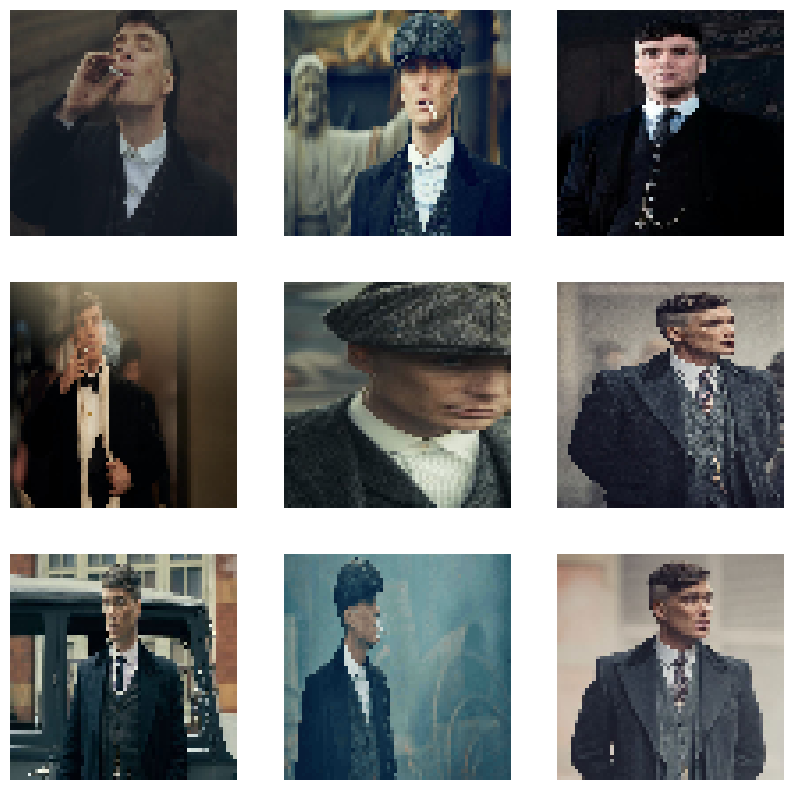

In [8]:
plt.figure(figsize=(10, 10))
# for images in x_train.shape[0]:
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i])
    plt.axis("off")

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)

In [11]:
normalized_ds = train_dataset.map(lambda x: normalization_layer(x_train))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Building the model

In [12]:
input_encoder = (64, 64, 3)
input_decoder = (5,)

In [13]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    print(epsilon)
    return mean + K.exp(log_var / 2) * epsilon

In [14]:
sampling_model

<function __main__.sampling_model(distribution_params)>

### Encoder

In [15]:
def encoder(input_encoder):
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  

    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
    
    flatten = layers.Flatten()(x)
    mean = layers.Dense(5, name='mean')(flatten)
    log_var = layers.Dense(5, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [16]:
enc = encoder(input_encoder)

In [17]:
enc.output

(<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'log_var')>)

In [18]:
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 64, 64, 32)   896         ['input_layer[0][0]']            
                                                                                                  
 bn_1 (BatchNormalization)      (None, 64, 64, 32)   128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 64, 64, 32)   0           ['bn_1[0][0]']                   
                                                                                            

In [19]:
input_1 = (5,)
input_2 = (5,)

In [20]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [21]:
final = sampling(input_1,input_2)

Tensor("encoder_output/random_normal:0", shape=(None, 5), dtype=float32)


### Decoder

In [22]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(16384, name='dense_1')(inputs)
    x = layers.Reshape((16, 16, 64), name='Reshape_Layer')(x)
   
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block-4
    outputs = layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [23]:
dec = decoder(input_decoder)

In [24]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 5)]               0         
                                                                 
 dense_1 (Dense)             (None, 16384)             98304     
                                                                 
 Reshape_Layer (Reshape)     (None, 16, 16, 64)        0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

# Loss Function

In [25]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl = kl_loss(mean, log_var)
    return  r_loss + kl

# Training the model

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [27]:
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [28]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
        
          
        seed = image_batch[:25]
        display.clear_output(wait=True)
      
        enc.save_weights('Weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('Weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)

In [29]:
# os.makedirs('Weights', exist_ok=True)

In [30]:
# train(normalized_ds, 50)

In [31]:
enc.load_weights('Weights/enc_49.h5')
dec.load_weights('Weights/dec_49.h5')

## GUI

In [32]:
from tkinter import * 
  
root = Tk()  
root.geometry("200x200")

number_of_images = IntVar()

s1 = Scale( root, variable = number_of_images, from_ = 1, to = 20, )   
  
l3 = Label(root, text = "How Many Pictures")
  
s1.pack(anchor = CENTER) 
l3.pack(anchor = CENTER)
  
root.mainloop()

number_of_images = number_of_images.get()

## Reconstructing the Data with Latent-Vector Sampled from Normal Distribution

1/1 [==============================] - 0s 193ms/step


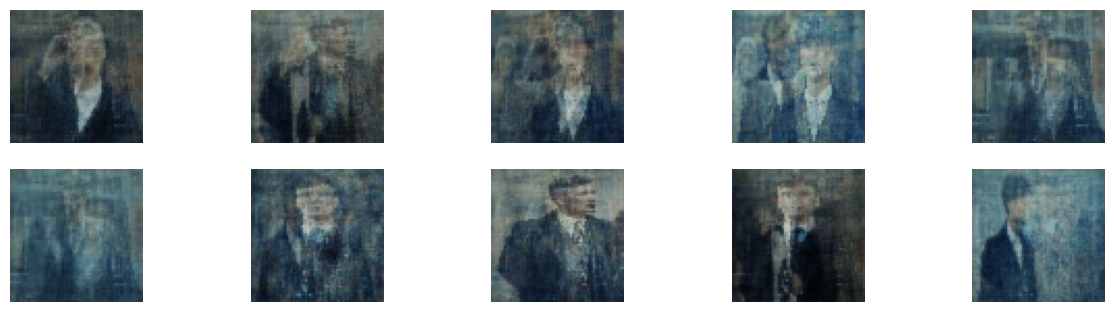

In [33]:
figsize = 15

x = np.random.normal(size = (number_of_images,5))
#x = np.random.uniform(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, number_of_images))

for i in range(number_of_images):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)